# SNVs: Illumina vs ONT

**Author**: Katarina Braun 


## Overview

This script cleans the VCF files generated by the `Sniffles` pipeline and generates "SNV correlation plots" to compare ONT and Illumina SNVs. 

**Visualize**: 
One scatterplot per gene where: 
- x Illumina SNV FREQ 
- y ONT SNV FREQ 
- datapoints are plotted as closed if nonsynonymous and open if synonymous

### a note about numbering schemes 

Everything was mapped to the Madison, WI case reference sequence: MT039887

The numbering schemes in input VCFs differs between the Illumina and ONT files. 
1. **Illumina**: starts from 1 at the beginning of each ORF. 
2. **ONT**: starts from 1 at the beginning of the reference file and increases sequentially through the entire genome. Some of the code below will adjust the numbering scheme in the ONT files to match the Illumina files -- but just make sure you are aware of this if you are looking at the upstream VCF files. 

## Input: 

1. SNV files in VCF format (output from `Sniffles`) located here: 
    - `SARSCoV2_passage_MS/data_derived/figure6_ONTvsIllumina/VCFs_Illumina/*` (6 files)
    
2. SNV files in VCF format (output from the ONT pipeline) located here: 
    - `SARSCoV2_passage_MS/data_derived/figure6_ONTvsIllumina/VCFs_ONT_min/*` (6 samples) 

## Output: 

1. Cleaned generated from VCF input files will be located here:       
    - `SARSCoV2_passage_MS/data_derived/figure6_ONTvsIllumina/VCFs_Illumina/cleaned/*`

2. Spliced data by sample ID, gene, and synonymous vs nonsynonymous will be located here:   
    - `SARSCoV2_passage_MS/data_derived/figure6_ONTvsIllumina/VCFs_Illumina/by_gene/*`

3. A PDF version of figure 6 will be written to the following location:   
    - `SARSCoV2_passage_MS/data_derived/figures/figure6.pdf`


### import modules and dependencies

In [180]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import glob
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pathlib import Path
from os.path import splitext
from functools import reduce
from pandas.api.types import is_numeric_dtype
import warnings
from pandas.core.common import SettingWithCopyWarning
from matplotlib.font_manager import FontProperties 
from matplotlib import cm
import itertools
from matplotlib import container
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib as mpl
import matplotlib.patches as mpatches

## data cleaning

### define functions for data cleaning

In [212]:
# get a list of filenames without the extension from some directory 
# example usage: `get_files('../data_derived/SNV', 'VCFlist')`
def get_files(path): 
    filelist = [os.path.splitext(filename)[0] for filename in os.listdir(path)]
    filelist.remove('.DS_Store')
    return(filelist)
#     print(filelist)

# load all text files in a directory into Pandas dataframes 
# path should be set to path to the text files that you would like to load into dataframes 
# set this function equal to some variable which will then be callable as a list of the dataframes 
# call each dataframe then calling items of the list, the specific sample name can be found within the VCF or dataframe
def load_dataframes(path):
    filelist = [os.path.splitext(file)[0] for file in os.listdir(path) if file.endswith('.vcf')]
    list_of_DFs = []
    for file in filelist: 
        DF = path + '/' + file + '.vcf'
        file = pd.read_csv(DF, header=0, sep='\t', low_memory=False)
        list_of_DFs.append(file)
    print(filelist)
    return(list_of_DFs)

# manipulate SNV dataframes 
# first run load_dataframes and generate a variable for the list of DFs, then feed that variable 
# into this function to clean the dataframe up and save to new CSV 
def clean_dataframes(path, list_of_DFs):
    if not os.path.exists(path + '/cleaned'):
            os.makedirs(path + '/cleaned')
    for DF in list_of_DFs:
        # save the specific animal ID and timepoint to a temporary name = sample 
        sample = DF.columns[9]
        # drop columns that are not needed
        DF.drop(['#CHROM', 'ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT'], axis=1)
        # replace . with "syn" (synonymous SNV) for clarity
        DF['AAchange'] = DF['AAchange'].replace({'.':'syn'})
#         DF['gene'] = DF['gene'].replace({'NA gene':'NA'})
        # create new column with GENE_REF-POS-ALT = SNP
        DF['SNP'] = DF['gene'] + '_' + DF['REF'] + DF['POS'].map(str) + DF['ALT']
        # delete rows in the dataframe that contain "not in ORF" -- I don't need to track these SNPs
        DF = DF[~DF['AAchange'].astype(str).str.contains('not in ORF')]
        # reorder the columns to make a little more sense
        DF = DF[['gene', 'POS', 'REF', 'ALT', 'FREQ', 'SNP']]
        # add a column to convert FREQ to % of the population 
        DF['% of population'] = DF['FREQ'].multiply(100)
        # make a cleaned directory if it does not already exist 
        if sample.endswith('_rep2'):
            sample_mod = sample[:-5]
            DF.to_csv(path + '/cleaned/' + sample_mod + '-cleaned.csv', sep='\t')
        else:
            DF.to_csv(path + '/cleaned/' + sample + '-cleaned.csv', sep='\t')
            
# manipulate SNV dataframes -- this function is specifically for the ONT VCFS, which are formatted a bit differently than the Illumina VCFs
# first run load_dataframes and generate a variable for the list of DFs, then feed that variable 
# into this function to clean the dataframe up and save to new CSV 
def clean_ONTdataframes(path, list_of_DFs):
    if not os.path.exists(path + '/cleaned'):
            os.makedirs(path + '/cleaned')
    AA_dict = {"Ala": "A", "Arg":"R", "Asn":"N", "Asp":"D", "Asx":"B", "Cys":"C", "Glu":"E", "Gln":"Q", "Glx":"Z", "Gly":"G", "His":"H", "Ile":"I", "Leu":"L", "Lys":"K", "Met":"M", "Phe":"F", "Pro":"P", "Ser":"S", "Thr":"T", "Trp":"W", "Tyr":"Y", "Val":"V"}
    gene_dict = {"orf1a":"ORF1a", "orf1b":"ORF1b", "s":"S", "orf3a":"ORF3a", "e":"E", "m":"M", "orf6":"ORF6", "orf7a":"ORF7a", "orf8":"ORF8", "n":"N", "orf10":"ORF10"}
    for DF in list_of_DFs:
        sample = DF.columns[10]
        # drop columns that are not needed
        DF = DF.drop(['#CHROM', 'ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT'], axis=1)
        DF[' Gene_ID '].replace('gene-','',regex=True,inplace=True)
        DF[' HGVS.p '].replace('p.','',regex=True,inplace=True)
        DF[' Annotation '].replace('_variant','',regex=True,inplace=True)
        DF[' Annotation '].replace('missence','nonsynonymous',regex=True,inplace=True)
        DF = DF.rename(columns={' Gene_ID ': 'gene', 'AF': 'FREQ'})
        DF['% of population'] = DF['FREQ'].multiply(100)
        DF['gene'] = DF['gene'].replace(gene_dict, regex=True)
        DF['SNP'] = DF['gene'] + '_' + DF['REF'] + DF['POS'].map(str) + DF['ALT']
#         DF['SNP'] = DF['SNP'].replace(AA_dict, regex=True)
        DF = DF[['gene', 'POS', 'REF', 'ALT', 'FREQ', 'SNP', '% of population']]
        # make a cleaned directory if it does not already exist 
        DF.to_csv(path + '/cleaned/' + sample + '-cleaned.csv', sep='\t')

### VCF file data-cleaning

In [213]:
# generate a list of dataframes, loaded from Illumina VCF files 
list_of_Illumina_DFs = load_dataframes('VCFs_Illumina/')

['p1_veroE6', 'p1_veroSTAT1KO', 'p2a_vero76', 'primary_NP_swab', 'p1_vero76', 'p2b_vero76']


In [214]:
# clean up all of the dataframes and save to new CSV files 
clean_dataframes('VCFs_Illumina/', list_of_Illumina_DFs)

In [215]:
# generate a list of dataframes, loaded from ONT VCF files 
list_of_ONT_DFs = load_dataframes('VCFs_ONT_min/')

['p1_veroE6', 'p1_veroSTAT1KO', 'p2a_vero76', 'primary_NP_swab', 'p1_vero76', 'p2b_vero76']


In [216]:
clean_ONTdataframes('VCFs_ONT_min/', list_of_ONT_DFs)

In [217]:
# load cleaned Illumina dataframes 
p1_vero76_Illumina = pd.read_csv('VCFs_Illumina/cleaned/p1_vero76-cleaned.csv', sep='\t')
p1_veroE6_Illumina = pd.read_csv('VCFs_Illumina/cleaned/p1_veroE6-cleaned.csv', sep='\t')
p1_veroSTAT1KO_Illumina = pd.read_csv('VCFs_Illumina/cleaned/p1_veroSTAT1KO-cleaned.csv', sep='\t')
p2a_vero76_Illumina = pd.read_csv('VCFs_Illumina/cleaned/p2a_vero76-cleaned.csv', sep='\t')
p2b_vero76_Illumina = pd.read_csv('VCFs_Illumina/cleaned/p2b_vero76-cleaned.csv', sep='\t')
primary_NP_swab_Illumina = pd.read_csv('VCFs_Illumina/cleaned/primary_NP_swab-cleaned.csv', sep='\t')

# load cleaned ONT dataframes 
p1_vero76_ONT = pd.read_csv('VCFs_ONT_min/cleaned/p1_vero76-cleaned.csv', sep='\t')
p1_veroE6_ONT = pd.read_csv('VCFs_ONT_min/cleaned/p1_veroE6-cleaned.csv', sep='\t')
p1_veroSTAT1KO_ONT = pd.read_csv('VCFs_ONT_min/cleaned/p1_veroSTAT1KO-cleaned.csv', sep='\t')
p2a_vero76_ONT = pd.read_csv('VCFs_ONT_min/cleaned/p2a_vero76-cleaned.csv', sep='\t')
p2b_vero76_ONT = pd.read_csv('VCFs_ONT_min/cleaned/p2b_vero76-cleaned.csv', sep='\t')
primary_NP_swab_ONT = pd.read_csv('VCFs_ONT_min/cleaned/primary_NP_swab-cleaned.csv', sep='\t')

##

## slice dataframes into genes and synonymous vs nonsynonymous SNPs

### define functions to slice dataframes into genes syn vs nonsyn SNPs

In [218]:
# slice merged ferret dataframe into individual genes and synonymous and nonsynonymous variants 

DF_slices = ['ORF1a_syn', 'ORF1a_nonsyn', 'ORF1b_syn', 'ORF1b_nonsyn', 'S_syn', 'S_nonsyn', 'ORF3a_syn', 'ORF3a_nonsyn', 'E_syn', 'E_nonsyn', 'M_syn', 'M_nonsyn', 'ORF6_syn', 'ORF6_nonsyn', 'ORF7a_syn', 'ORF7a_nonsyn', 'ORF8_syn', 'ORF8_nonsyn', 'N_syn', 'N_nonsyn', 'ORF10_syn', 'ORF10_nonsyn']
genes = ['ORF1a_', 'ORF1b_', 'S_', 'ORF3a_', 'E_', 'M_', 'ORF6_', 'ORF7a_', 'ORF8_', 'N_', 'ORF10_']
strings = [6, 6, 2, 6, 2, 2, 6, 6, 6, 2, 7]

# genes, strings and path are defined above, this shouldn't be changed
def slice_dataframes(sample, samplenum, DF_slices, genes, strings, path):
    if not os.path.exists(path + '/by_gene_segment/' + samplenum):
            os.makedirs(path + '/by_gene_segment/' + samplenum)
    DF = sample
    for DF_slice in DF_slices: 
        DF_slice = pd.DataFrame()
    DF_by_gene = []
    for (gene, string) in zip(genes, strings):
        gene = DF.loc[DF['SNP'].str.contains(gene)]
        if gene.empty:
            pass
        else: 
            gene['SNP'] = gene['SNP'].map(lambda x : str(x)[string:])
            gene['POS'] = gene['SNP'].str.extract('(\d+)')
            gene['POS'] = pd.to_numeric(gene['POS'])
            gene = gene.sort_values(by=['POS'])
            gene = gene.drop(['POS'], axis=1)
        DF_by_gene.append(gene)
#     return(DF_by_gene)
    DF_slices = []
    for (DF, gene) in zip(DF_by_gene, genes): 
        if DF.empty is False:
            DF_syn = DF.loc[DF['SNP'].str.contains("syn")]
            DF_syn['SNP'] = gene + DF_syn['SNP'].astype(str)
            DF_nonsyn = DF.loc[~DF['SNP'].str.contains("syn")]
            DF_nonsyn['SNP'] = gene + DF_nonsyn['SNP'].astype(str)
            # save these dataframes to CSV files
            if DF_syn.empty is False: 
                DF_syn.to_csv(path + '/by_gene_segment/' + samplenum + '/' + gene + '_syn.csv', sep='\t')
            if DF_nonsyn.empty is False:  
                DF_nonsyn.to_csv(path + '/by_gene_segment/' + samplenum + '/' + gene + '_nonsyn.csv', sep='\t')
        else: 
            pass
            
##

In [219]:
# ignore some errors that will pop up 
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

DF_slices = ['ORF1a_syn', 'ORF1a_nonsyn', 'ORF1b_syn', 'ORF1b_nonsyn', 'S_syn', 'S_nonsyn', 'ORF3a_syn', 'ORF3a_nonsyn', 'E_syn', 'E_nonsyn', 'M_syn', 'M_nonsyn', 'ORF6_syn', 'ORF6_nonsyn', 'ORF7a_syn', 'ORF7a_nonsyn', 'ORF8_syn', 'ORF8_nonsyn', 'N_syn', 'N_nonsyn', 'ORF10_syn', 'ORF10_nonsyn']
genes = ['ORF1a_', 'ORF1b_', 'S_', 'ORF3a_', 'E_', 'M_', 'ORF6_', 'ORF7a_', 'ORF8_', 'N_', 'ORF10_']
strings = [6, 6, 2, 6, 2, 2, 6, 6, 6, 2, 7]

# slice all Illumina merged dataframes into gene segments as well as synonymous and nonsynonymoust variants 
p1_vero76_Illumina_slices = slice_dataframes(p1_vero76_Illumina, 'p1_vero76_Illumina', DF_slices, genes, strings, 'VCFs_Illumina/')
p1_veroE6_Illumina_slices = slice_dataframes(p1_veroE6_Illumina, 'p1_veroE6_Illumina', DF_slices, genes, strings, 'VCFs_Illumina/')
p1_veroSTAT1KO_Illumina_slices = slice_dataframes(p1_veroSTAT1KO_Illumina, 'p1_veroSTAT1KO_Illumina', DF_slices, genes, strings, 'VCFs_Illumina/')
p2a_vero76_Illumina_slices = slice_dataframes(p2a_vero76_Illumina, 'p2a_vero76_Illumina', DF_slices, genes, strings, 'VCFs_Illumina/')
p2b_vero76_Illumina_slices = slice_dataframes(p2b_vero76_Illumina, 'p2b_vero76_Illumina', DF_slices, genes, strings, 'VCFs_Illumina/')
primary_NP_swab_Illumina_slices = slice_dataframes(primary_NP_swab_Illumina, 'primary_NP_swab_Illumina', DF_slices, genes, strings, 'VCFs_Illumina/')

# slice all ONT merged dataframes into gene segments as well as synonymous and nonsynonymoust variants 
p1_vero76_ONT_slices = slice_dataframes(p1_vero76_ONT, 'p1_vero76_ONT', DF_slices, genes, strings, 'VCFs_ONT_min/')
p1_veroE6_ONT_slices = slice_dataframes(p1_veroE6_ONT, 'p1_veroE6_ONT', DF_slices, genes, strings, 'VCFs_ONT_min/')
p1_veroSTAT1KO_ONT_slices = slice_dataframes(p1_veroSTAT1KO_ONT, 'p1_veroSTAT1KO_ONT', DF_slices, genes, strings, 'VCFs_ONT_min/')
p2a_vero76_ONT_slices = slice_dataframes(p2a_vero76_ONT, 'p2a_vero76_ONT', DF_slices, genes, strings, 'VCFs_ONT_min/')
p2b_vero76_ONT_slices = slice_dataframes(p2b_vero76_ONT, 'p2b_vero76_ONT', DF_slices, genes, strings, 'VCFs_ONT_min/')
primary_NP_swab_ONT_slices = slice_dataframes(primary_NP_swab_ONT, 'primary_NP_swab_ONT', DF_slices, genes, strings, 'VCFs_ONT_min/')

###

In [251]:
# define hex codes for genes (these colors match the gene colors found in figure 1)

ORF1a = '#e49635'
ORF1b = '#a9bc50'
S = '#d8ac3b'
ORF3a = '#dd4528'
E = '#d8ac3b'
M = '#5096ba'
ORF6 = '#c5b944'
ORF7a = '#75b580'
ORF8 = '#5faa9d'
N = '#e6712f'
ORF10 = '#8ebc65'



In [252]:
# load the cleaned CSV files into dataframes 

primary_NP_swab_ONT = pd.read_csv('VCFs_ONT_min/cleaned/primary_NP_swab-cleaned.csv', sep='\t')
primary_NP_swab_ONT = primary_NP_swab_ONT[['FREQ', 'SNP']]
primary_NP_swab_ONT = primary_NP_swab_ONT.rename(columns={'FREQ': 'FREQ_ONT'})

In [253]:
# load the cleaned CSV files into dataframes 

primary_NP_swab_Illumina = pd.read_csv('VCFs_Illumina/cleaned/primary_NP_swab-cleaned.csv', sep='\t')
primary_NP_swab_Illumina = primary_NP_swab_Illumina[['FREQ', 'SNP']]
primary_NP_swab_Illumina = primary_NP_swab_Illumina.rename(columns={'FREQ': 'FREQ_Illumina'})

In [254]:
# load the cleaned CSV files into dataframes 

p1_vero76_ONT = pd.read_csv('VCFs_ONT_min/cleaned/p1_vero76-cleaned.csv', sep='\t')
p1_vero76_ONT = p1_vero76_ONT[['FREQ', 'SNP']]
p1_vero76_ONT = p1_vero76_ONT.rename(columns={'FREQ': 'FREQ_ONT'})


In [255]:
# load the cleaned CSV files into dataframes 

p1_vero76_Illumina = pd.read_csv('VCFs_Illumina/cleaned/p1_vero76-cleaned.csv', sep='\t')
p1_vero76_Illumina = p1_vero76_Illumina[['FREQ', 'SNP']]
p1_vero76_Illumina = p1_vero76_Illumina.rename(columns={'FREQ': 'FREQ_Illumina'})


In [256]:
# load the cleaned CSV files into dataframes 

p1_veroE6_ONT = pd.read_csv('VCFs_ONT_min/cleaned/p1_veroE6-cleaned.csv', sep='\t')
p1_veroE6_ONT = p1_veroE6_ONT[['FREQ', 'SNP']]
p1_veroE6_ONT = p1_veroE6_ONT.rename(columns={'FREQ': 'FREQ_ONT'})


In [257]:
# load the cleaned CSV files into dataframes 

p1_veroE6_Illumina = pd.read_csv('VCFs_Illumina/cleaned/p1_veroE6-cleaned.csv', sep='\t')
p1_veroE6_Illumina = p1_veroE6_Illumina[['FREQ', 'SNP']]
p1_veroE6_Illumina = p1_veroE6_Illumina.rename(columns={'FREQ': 'FREQ_Illumina'})


In [258]:
# load the cleaned CSV files into dataframes 

p1_veroSTAT1KO_ONT = pd.read_csv('VCFs_ONT_min/cleaned/p1_veroSTAT1KO-cleaned.csv', sep='\t')
p1_veroSTAT1KO_ONT = p1_veroSTAT1KO_ONT[['FREQ', 'SNP']]
p1_veroSTAT1KO_ONT = p1_veroSTAT1KO_ONT.rename(columns={'FREQ': 'FREQ_ONT'})


In [259]:
# load the cleaned CSV files into dataframes 

p1_veroSTAT1KO_Illumina = pd.read_csv('VCFs_Illumina/cleaned/p1_veroSTAT1KO-cleaned.csv', sep='\t')
p1_veroSTAT1KO_Illumina = p1_veroSTAT1KO_Illumina[['FREQ', 'SNP']]
p1_veroSTAT1KO_Illumina = p1_veroSTAT1KO_Illumina.rename(columns={'FREQ': 'FREQ_Illumina'})


In [260]:
# load the cleaned CSV files into dataframes 

p2a_vero76_ONT = pd.read_csv('VCFs_ONT_min/cleaned/p2a_vero76-cleaned.csv', sep='\t')
p2a_vero76_ONT = p2a_vero76_ONT[['FREQ', 'SNP']]
p2a_vero76_ONT = p2a_vero76_ONT.rename(columns={'FREQ': 'FREQ_ONT'})


In [261]:
# load the cleaned CSV files into dataframes 

p2a_vero76_Illumina = pd.read_csv('VCFs_Illumina/cleaned/p2a_vero76-cleaned.csv', sep='\t')
p2a_vero76_Illumina = p2a_vero76_Illumina[['FREQ', 'SNP']]
p2a_vero76_Illumina = p2a_vero76_Illumina.rename(columns={'FREQ': 'FREQ_Illumina'})


In [262]:
# load the cleaned CSV files into dataframes 

p2b_vero76_ONT = pd.read_csv('VCFs_ONT_min/cleaned/p2b_vero76-cleaned.csv', sep='\t')
p2b_vero76_ONT = p2b_vero76_ONT[['FREQ', 'SNP']]
p2b_vero76_ONT = p2b_vero76_ONT.rename(columns={'FREQ': 'FREQ_ONT'})


In [263]:
# load the cleaned CSV files into dataframes 

p2b_vero76_Illumina = pd.read_csv('VCFs_Illumina/cleaned/p2b_vero76-cleaned.csv', sep='\t')
p2b_vero76_Illumina = p2b_vero76_Illumina[['FREQ', 'SNP']]
p2b_vero76_Illumina = p2b_vero76_Illumina.rename(columns={'FREQ': 'FREQ_Illumina'})


In [264]:
# merge ONT and Illumina dataframes 

primary_NP_swab = pd.merge(primary_NP_swab_ONT, primary_NP_swab_Illumina, how='outer', on=['SNP'])
primary_NP_swab.loc[primary_NP_swab['SNP'].str.contains('ORF1a'), 'color'] = ORF1a
primary_NP_swab.loc[primary_NP_swab['SNP'].str.contains('ORF1b'), 'color'] = ORF1b
primary_NP_swab.loc[primary_NP_swab['SNP'].str.contains('S'), 'color'] = S
primary_NP_swab.loc[primary_NP_swab['SNP'].str.contains('ORF3a'), 'color'] = ORF3a
primary_NP_swab.loc[primary_NP_swab['SNP'].str.contains('E'), 'color'] = E
primary_NP_swab.loc[primary_NP_swab['SNP'].str.contains('M'), 'color'] = M
primary_NP_swab.loc[primary_NP_swab['SNP'].str.contains('ORF6'), 'color'] = ORF6
primary_NP_swab.loc[primary_NP_swab['SNP'].str.contains('ORF7a'), 'color'] = ORF7a
primary_NP_swab.loc[primary_NP_swab['SNP'].str.contains('ORF8'), 'color'] = ORF8
primary_NP_swab.loc[primary_NP_swab['SNP'].str.contains('N'), 'color'] = N
primary_NP_swab.loc[primary_NP_swab['SNP'].str.contains('ORF10'), 'color'] = ORF10
primary_NP_swab = primary_NP_swab[['SNP', 'FREQ_ONT', 'FREQ_Illumina', 'color']]


In [265]:
# merge ONT and Illumina dataframes 

p1_vero76 = pd.merge(p1_vero76_ONT, p1_vero76_Illumina, how='outer', on=['SNP'])
p1_vero76.loc[p1_vero76['SNP'].str.contains('ORF1a'), 'color'] = ORF1a
p1_vero76.loc[p1_vero76['SNP'].str.contains('ORF1b'), 'color'] = ORF1b
p1_vero76.loc[p1_vero76['SNP'].str.contains('S'), 'color'] = S
p1_vero76.loc[p1_vero76['SNP'].str.contains('ORF3a'), 'color'] = ORF3a
p1_vero76.loc[p1_vero76['SNP'].str.contains('E'), 'color'] = E
p1_vero76.loc[p1_vero76['SNP'].str.contains('M'), 'color'] = M
p1_vero76.loc[p1_vero76['SNP'].str.contains('ORF6'), 'color'] = ORF6
p1_vero76.loc[p1_vero76['SNP'].str.contains('ORF7a'), 'color'] = ORF7a
p1_vero76.loc[p1_vero76['SNP'].str.contains('ORF8'), 'color'] = ORF8
p1_vero76.loc[p1_vero76['SNP'].str.contains('N'), 'color'] = N
p1_vero76.loc[p1_vero76['SNP'].str.contains('ORF10'), 'color'] = ORF10
p1_vero76 = p1_vero76[['SNP', 'FREQ_ONT', 'FREQ_Illumina', 'color']]

In [266]:
# merge ONT and Illumina dataframes 

p1_veroE6 = pd.merge(p1_veroE6_ONT, p1_veroE6_Illumina, how='outer', on=['SNP'])
p1_veroE6.loc[p1_veroE6['SNP'].str.contains('ORF1a'), 'color'] = ORF1a
p1_veroE6.loc[p1_veroE6['SNP'].str.contains('ORF1b'), 'color'] = ORF1b
p1_veroE6.loc[p1_veroE6['SNP'].str.contains('S'), 'color'] = S
p1_veroE6.loc[p1_veroE6['SNP'].str.contains('ORF3a'), 'color'] = ORF3a
p1_veroE6.loc[p1_veroE6['SNP'].str.contains('E'), 'color'] = E
p1_veroE6.loc[p1_veroE6['SNP'].str.contains('M'), 'color'] = M
p1_veroE6.loc[p1_veroE6['SNP'].str.contains('ORF6'), 'color'] = ORF6
p1_veroE6.loc[p1_veroE6['SNP'].str.contains('ORF7a'), 'color'] = ORF7a
p1_veroE6.loc[p1_veroE6['SNP'].str.contains('ORF8'), 'color'] = ORF8
p1_veroE6.loc[p1_veroE6['SNP'].str.contains('N'), 'color'] = N
p1_veroE6.loc[p1_veroE6['SNP'].str.contains('ORF10'), 'color'] = ORF10
p1_veroE6 = p1_veroE6[['SNP', 'FREQ_ONT', 'FREQ_Illumina', 'color']]

In [267]:
# merge ONT and Illumina dataframes 

p1_veroSTAT1KO = pd.merge(p1_veroSTAT1KO_ONT, p1_veroSTAT1KO_Illumina, how='outer', on=['SNP'])
p1_veroSTAT1KO.loc[p1_veroSTAT1KO['SNP'].str.contains('ORF1a'), 'color'] = ORF1a
p1_veroSTAT1KO.loc[p1_veroSTAT1KO['SNP'].str.contains('ORF1b'), 'color'] = ORF1b
p1_veroSTAT1KO.loc[p1_veroSTAT1KO['SNP'].str.contains('S'), 'color'] = S
p1_veroSTAT1KO.loc[p1_veroSTAT1KO['SNP'].str.contains('ORF3a'), 'color'] = ORF3a
p1_veroSTAT1KO.loc[p1_veroSTAT1KO['SNP'].str.contains('E'), 'color'] = E
p1_veroSTAT1KO.loc[p1_veroSTAT1KO['SNP'].str.contains('M'), 'color'] = M
p1_veroSTAT1KO.loc[p1_veroSTAT1KO['SNP'].str.contains('ORF6'), 'color'] = ORF6
p1_veroSTAT1KO.loc[p1_veroSTAT1KO['SNP'].str.contains('ORF7a'), 'color'] = ORF7a
p1_veroSTAT1KO.loc[p1_veroSTAT1KO['SNP'].str.contains('ORF8'), 'color'] = ORF8
p1_veroSTAT1KO.loc[p1_veroSTAT1KO['SNP'].str.contains('N'), 'color'] = N
p1_veroSTAT1KO.loc[p1_veroSTAT1KO['SNP'].str.contains('ORF10'), 'color'] = ORF10
p1_veroSTAT1KO = p1_veroSTAT1KO[['SNP', 'FREQ_ONT', 'FREQ_Illumina', 'color']]

In [268]:
# merge ONT and Illumina dataframes 

p2a_vero76 = pd.merge(p2a_vero76_ONT, p2a_vero76_Illumina, how='outer', on=['SNP'])
p2a_vero76.loc[p2a_vero76['SNP'].str.contains('ORF1a'), 'color'] = ORF1a
p2a_vero76.loc[p2a_vero76['SNP'].str.contains('ORF1b'), 'color'] = ORF1b
p2a_vero76.loc[p2a_vero76['SNP'].str.contains('S'), 'color'] = S
p2a_vero76.loc[p2a_vero76['SNP'].str.contains('ORF3a'), 'color'] = ORF3a
p2a_vero76.loc[p2a_vero76['SNP'].str.contains('E'), 'color'] = E
p2a_vero76.loc[p2a_vero76['SNP'].str.contains('M'), 'color'] = M
p2a_vero76.loc[p2a_vero76['SNP'].str.contains('ORF6'), 'color'] = ORF6
p2a_vero76.loc[p2a_vero76['SNP'].str.contains('ORF7a'), 'color'] = ORF7a
p2a_vero76.loc[p2a_vero76['SNP'].str.contains('ORF8'), 'color'] = ORF8
p2a_vero76.loc[p2a_vero76['SNP'].str.contains('N'), 'color'] = N
p2a_vero76.loc[p2a_vero76['SNP'].str.contains('ORF10'), 'color'] = ORF10
p2a_vero76 = p2a_vero76[['SNP', 'FREQ_ONT', 'FREQ_Illumina', 'color']]

In [269]:
# merge ONT and Illumina dataframes 

p2b_vero76 = pd.merge(p2b_vero76_ONT, p2b_vero76_Illumina, how='outer', on=['SNP'])
p2b_vero76.loc[p2b_vero76['SNP'].str.contains('ORF1a'), 'color'] = ORF1a
p2b_vero76.loc[p2b_vero76['SNP'].str.contains('ORF1b'), 'color'] = ORF1b
p2b_vero76.loc[p2b_vero76['SNP'].str.contains('S'), 'color'] = S
p2b_vero76.loc[p2b_vero76['SNP'].str.contains('ORF3a'), 'color'] = ORF3a
p2b_vero76.loc[p2b_vero76['SNP'].str.contains('E'), 'color'] = E
p2b_vero76.loc[p2b_vero76['SNP'].str.contains('M'), 'color'] = M
p2b_vero76.loc[p2b_vero76['SNP'].str.contains('ORF6'), 'color'] = ORF6
p2b_vero76.loc[p2b_vero76['SNP'].str.contains('ORF7a'), 'color'] = ORF7a
p2b_vero76.loc[p2b_vero76['SNP'].str.contains('ORF8'), 'color'] = ORF8
p2b_vero76.loc[p2b_vero76['SNP'].str.contains('N'), 'color'] = N
p2b_vero76.loc[p2b_vero76['SNP'].str.contains('ORF10'), 'color'] = ORF10
p2b_vero76 = p2b_vero76[['SNP', 'FREQ_ONT', 'FREQ_Illumina', 'color']]

In [270]:
# do some final formatting of these dataframes

primary_NP_swab = primary_NP_swab.replace(np.nan, 0)
p1_vero76 = p1_vero76.replace(np.nan, 0)
p1_veroE6 = p1_veroE6.replace(np.nan, 0)
p1_veroSTAT1KO = p1_veroSTAT1KO.replace(np.nan, 0)
p2a_vero76 = p2a_vero76.replace(np.nan, 0)
p2b_vero76 = p2b_vero76.replace(np.nan, 0)

#

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


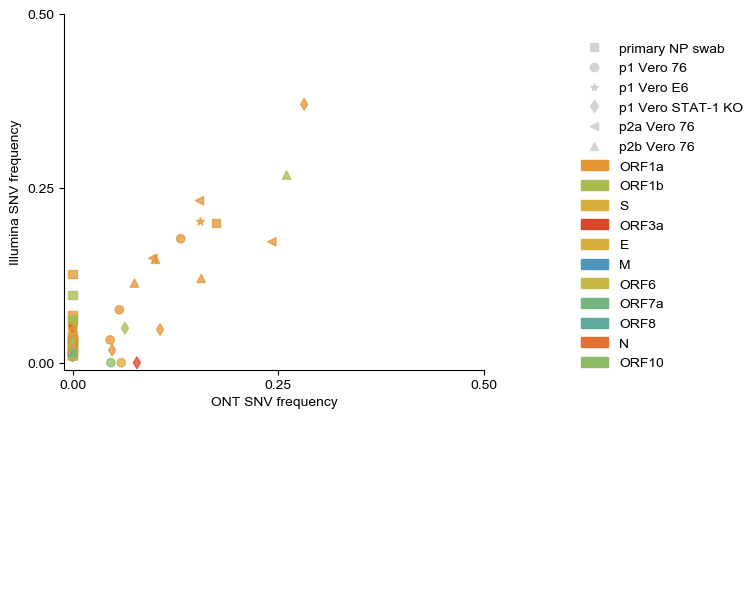

In [275]:
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(14,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 12)

ax1 = fig.add_subplot(gs[0,0:4]) # JT/TV plot

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)
    
# edit the axes - ax1
ax1.set_title('', fontname='Arial', fontsize=14)
ax1.set_ylabel('Illumina SNV frequency', fontname='Arial', fontsize=10)
ax1.set_xlabel('ONT SNV frequency', fontname='Arial', fontsize=10)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-0.01,0.5)
ax1.set_yticks([0,0.25,0.5])
ax1.set_xlim(-0.01,0.5)
ax1.set_xticks([0,0.25,0.5])

# FOR PLOT ax1 
ax1.scatter(primary_NP_swab.FREQ_ONT, primary_NP_swab.FREQ_Illumina, color=primary_NP_swab['color'], marker='s', alpha=0.75)
ax1.scatter(p1_vero76.FREQ_ONT, p1_vero76.FREQ_Illumina, color=p1_vero76['color'], marker='o', alpha=0.75)
ax1.scatter(p1_veroE6.FREQ_ONT, p1_veroE6.FREQ_Illumina, color=p1_veroE6['color'], marker='*', alpha=0.75)
ax1.scatter(p1_veroSTAT1KO.FREQ_ONT, p1_veroSTAT1KO.FREQ_Illumina, color=p1_veroSTAT1KO['color'], marker='d', alpha=0.75)
ax1.scatter(p2a_vero76.FREQ_ONT, p2a_vero76.FREQ_Illumina, color=p2a_vero76['color'], marker='<', alpha=0.75)
ax1.scatter(p2b_vero76.FREQ_ONT, p2b_vero76.FREQ_Illumina, color=p2b_vero76['color'], marker='^', alpha=0.75)


# add a legend to this plot

# viruses
swab = mlines.Line2D([], [], marker='s', color='lightgrey', linestyle='None', markersize=6, label='primary NP swab')
p176 = mlines.Line2D([], [], marker='o', color='lightgrey', linestyle='None', markersize=6, label='p1 Vero 76')
p1e6 = mlines.Line2D([], [], marker='*', color='lightgrey', linestyle='None', markersize=6, label='p1 Vero E6')
p1s = mlines.Line2D([], [], marker='d', color='lightgrey', linestyle='None', markersize=6, label='p1 Vero STAT-1 KO')
p2a = mlines.Line2D([], [], marker='<', color='lightgrey', linestyle='None', markersize=6, label='p2a Vero 76')
p2b = mlines.Line2D([], [], marker='^', color='lightgrey', linestyle='None', markersize=6, label='p2b Vero 76')

# color patches = gene
ORF1a = mpatches.Patch(color='#e49635', label='ORF1a')
ORF1b = mpatches.Patch(color='#a9bc50', label='ORF1b')
S = mpatches.Patch(color='#d8ac3b', label='S')
ORF3a = mpatches.Patch(color='#dd4528', label='ORF3a')
E = mpatches.Patch(color='#d8ac3b', label='E')
M = mpatches.Patch(color='#5096ba', label='M')
ORF6 = mpatches.Patch(color='#c5b944', label='ORF6')
ORF7a = mpatches.Patch(color='#75b580', label='ORF7a')
ORF8 = mpatches.Patch(color='#5faa9d', label='ORF8')
N = mpatches.Patch(color='#e6712f', label='N')
ORF10 = mpatches.Patch(color='#8ebc65', label='ORF10')

fig.legend(handles=[swab, p176, p1e6, p1s, p2a, p2b, ORF1a, ORF1b, S, ORF3a, E, M, ORF6, ORF7a, ORF8, N, ORF10], frameon=False, fontsize=10, bbox_to_anchor=(0.54,0.7))

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../../figures/ONT-vs-Illumina_SNVs.pdf", bbox_inches='tight', dpi=300)
